# MNIST: learning to recognize handwritten digits

## Dataset exploration

Before starting a machine learning or data science task, it is always useful to familiarize yourself with the data set and its context.

### Required imports

In [1]:
from collections import Counter
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Using TensorFlow backend.


### Obtaining the dataset

In Keras' datasets module we have a handle to the MNIST dataset we want to use in this notebook.  Download the training and test set for this data.

In [84]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Dimensions and types

Determine the shape and type of the training and the test set.

In [3]:
x_train.shape, x_train.dtype, y_train.shape, y_train.dtype

((60000, 28, 28), dtype('uint8'), (60000,), dtype('uint8'))

In [4]:
x_test.shape, x_test.dtype, y_test.shape, y_test.dtype

((10000, 28, 28), dtype('uint8'), (10000,), dtype('uint8'))

The training set has 60,000 examples, the test set 10,000.  The input is a 28 $\times$ 28 matrix of unsigned 8-bit integers, the output a single unsigned 8-bit integer.

### Data semantics

 Each input represents a scanned grayscale image of a handwritten digit, the output is the corresponding integer.

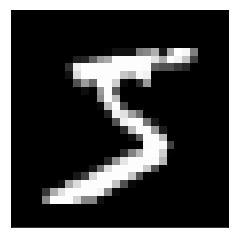

In [5]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0], cmap='gray');

In [6]:
y_train[0]

5

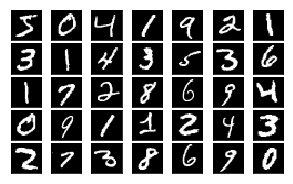

In [7]:
rows = 5
cols = 7
figure, axes = plt.subplots(rows, cols, figsize=(5, 3))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for img_nr in range(rows*cols):
    row = img_nr//cols
    col = img_nr % cols
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].imshow(x_train[img_nr], cmap='gray')

In [8]:
y_train[:rows*cols].reshape(rows, cols)

array([[5, 0, 4, 1, 9, 2, 1],
       [3, 1, 4, 3, 5, 3, 6],
       [1, 7, 2, 8, 6, 9, 4],
       [0, 9, 1, 1, 2, 4, 3],
       [2, 7, 3, 8, 6, 9, 0]], dtype=uint8)

So this proves that I'm certainly not the only one cursed with bad handwriting.

### Data distribution

An important question is whether all digits are represented in the training and test set, and what the distribution is.  This may have an impact on the accuracy of the trained model.

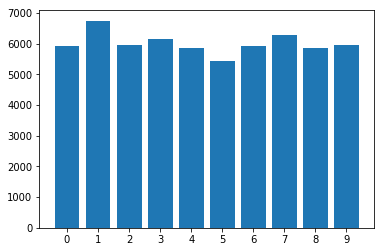

In [9]:
distr = Counter(y_train)
figure, axes = plt.subplots()
axes.set_xticks(list(distr.keys()))
axes.bar(list(distr.keys()), list(distr.values()));

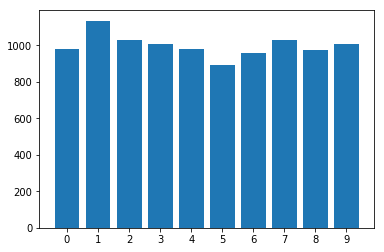

In [10]:
distr = Counter(y_test)
figure, axes = plt.subplots()
axes.set_xticks(list(distr.keys()))
axes.bar(list(distr.keys()), list(distr.values()));

Although some digits like 1 are overrepresented, and others, e.g., 5 are underrepresented, the distribution seems to be reasonably uniform, and it is likely no special care needs to be taken.

## Data preparation

Before we can start doing machine learning on the data, some preparations are required.  In this case, the data set is clean, which simplifies this step considerably.  Although it would be better to create a pipeline using the scikit-learn framework, we'll do the preparation by hand in this case.

### Required imports

In [21]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

### Transforming the data

Rather than using the 28 $\times$ 28 images as input, we reshape each image to a 784 array.

In [85]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

Most learning algorithms work better when the input data is normalized to the interval $[0, 1]$.

In [86]:
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

The output can be transformed to categorical data, i.e., one category for each digit, rather than a `uint8`. This is a one-hot encoding, so the output is now an array consisting of a single 1.0 value, and nine 0.0 values.  Note that the type of the output is now also `float32`.

In [87]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [20]:
y_train.shape

(60000, 10)

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

### Validation set

In order to make this reproducible, we have to seed the random number generator.

In [25]:
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [27]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((33750, 784), (11250, 784), (33750, 10), (11250, 10))

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

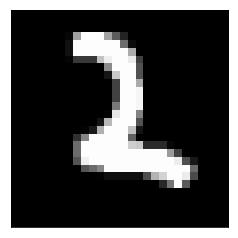

In [29]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray');

In [30]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Everything seems fine, input/output are as expected, and we can start doing some machine learning.

## Classic multilayer neural network

We start off training a classic multilayer neural network to familiarie ourselves with the keras framework.

### Required imports

In [90]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

### Model definition

We will create a fully connected neural network with 784 input units (28 $\times$ 28 pixels), two hidden layers with 512 units each, and an output layter with 10 units (ten categories, one per digit). For the two hidden layers, we will use a ReLU activation function, and a SoftMax for the output layer.

In [59]:
np.random.seed(1234)

In [60]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Now we can can compile the model, specifying the loss function (categorical cross-entropy), the optimizer (SGD, Stochastic Gradient Descent), and the metrics (accuracy) we want to use.

In [62]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Training

In [63]:
model_history = model.fit(x_train, y_train, batch_size=128, epochs=100,
                          verbose=1, validation_data=(x_val, y_val))

Train on 33750 samples, validate on 11250 samples
Epoch 1/100
33750/33750 [==============================] - 16s 468us/step - loss: 1.4363 - acc: 0.6875 - val_loss: 0.8013 - val_acc: 0.8413
Epoch 2/100
33750/33750 [==============================] - 14s 402us/step - loss: 0.6198 - acc: 0.8574 - val_loss: 0.5072 - val_acc: 0.8773
Epoch 3/100
33750/33750 [==============================] - 15s 455us/step - loss: 0.4533 - acc: 0.8821 - val_loss: 0.4162 - val_acc: 0.8933
Epoch 4/100
33750/33750 [==============================] - 13s 371us/step - loss: 0.3880 - acc: 0.8951 - val_loss: 0.3716 - val_acc: 0.8996
Epoch 5/100
33750/33750 [==============================] - 14s 401us/step - loss: 0.3515 - acc: 0.9034 - val_loss: 0.3460 - val_acc: 0.9041
Epoch 6/100
33750/33750 [==============================] - 13s 379us/step - loss: 0.3266 - acc: 0.9097 - val_loss: 0.3250 - val_acc: 0.9090
Epoch 7/100
33750/33750 [==============================] - 11s 324us/step - loss: 0.3084 - acc: 0.9137 - val_l

Epoch 59/100
33750/33750 [==============================] - 11s 326us/step - loss: 0.0915 - acc: 0.9749 - val_loss: 0.1341 - val_acc: 0.9627
Epoch 60/100
33750/33750 [==============================] - 11s 330us/step - loss: 0.0903 - acc: 0.9755 - val_loss: 0.1306 - val_acc: 0.9643
Epoch 61/100
33750/33750 [==============================] - 11s 321us/step - loss: 0.0887 - acc: 0.9761 - val_loss: 0.1301 - val_acc: 0.9641
Epoch 62/100
33750/33750 [==============================] - 15s 433us/step - loss: 0.0872 - acc: 0.9764 - val_loss: 0.1289 - val_acc: 0.9644
Epoch 63/100
33750/33750 [==============================] - 14s 414us/step - loss: 0.0857 - acc: 0.9768 - val_loss: 0.1281 - val_acc: 0.9644
Epoch 64/100
33750/33750 [==============================] - 11s 325us/step - loss: 0.0843 - acc: 0.9776 - val_loss: 0.1265 - val_acc: 0.9650
Epoch 65/100
33750/33750 [==============================] - 11s 328us/step - loss: 0.0830 - acc: 0.9779 - val_loss: 0.1259 - val_acc: 0.9654
Epoch 66/100


Plot the history of the training process.

In [64]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')

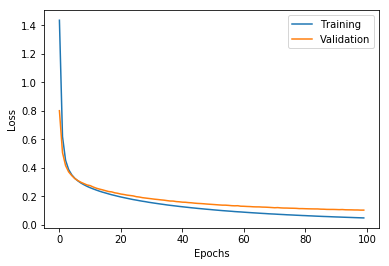

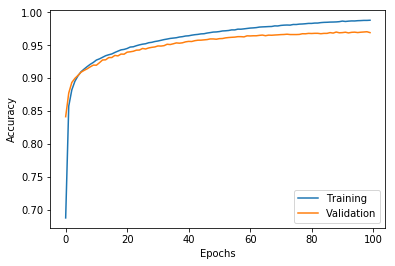

In [65]:
plot_history(model_history)

Let's compare the performance of the model on the training, validation and test set.

model.evaluate(x_train, y_train

In [ ]:
model.evaluate(x_val, y_val)

In [88]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 6s 593us/step


[0.08850426195478067, 0.9738]

### Dropout layers

In order to reduce overfitting, drop out can be applied, i.e., randomly setting input values to 0 during training. We add a drop-out layer between the hidden layers, and between the last hidden layer and the output layer.

In [72]:
np.random.seed(1234)

In [73]:
dropout_model = Sequential()
dropout_model.add(Dense(512, activation='relu', input_shape=(784,)))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(512, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(10, activation='softmax'))

In [74]:
dropout_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [75]:
dropout_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

In [76]:
dropout_model_history = dropout_model.fit(x_train, y_train, batch_size=128, epochs=100,
                          verbose=1, validation_data=(x_val, y_val))

Train on 33750 samples, validate on 11250 samples
Epoch 1/100
33750/33750 [==============================] - 25s 742us/step - loss: 1.5823 - acc: 0.5948 - val_loss: 0.8774 - val_acc: 0.8280
Epoch 2/100
33750/33750 [==============================] - 16s 469us/step - loss: 0.7405 - acc: 0.8111 - val_loss: 0.5280 - val_acc: 0.8683
Epoch 3/100
33750/33750 [==============================] - 16s 462us/step - loss: 0.5427 - acc: 0.8480 - val_loss: 0.4265 - val_acc: 0.8868
Epoch 4/100
33750/33750 [==============================] - 15s 457us/step - loss: 0.4663 - acc: 0.8677 - val_loss: 0.3787 - val_acc: 0.8954
Epoch 5/100
33750/33750 [==============================] - 15s 457us/step - loss: 0.4197 - acc: 0.8787 - val_loss: 0.3498 - val_acc: 0.9003
Epoch 6/100
33750/33750 [==============================] - 15s 455us/step - loss: 0.3911 - acc: 0.8849 - val_loss: 0.3294 - val_acc: 0.9048
Epoch 7/100
33750/33750 [==============================] - 16s 473us/step - loss: 0.3672 - acc: 0.8937 - val_l

Epoch 59/100
33750/33750 [==============================] - 16s 460us/step - loss: 0.1141 - acc: 0.9670 - val_loss: 0.1247 - val_acc: 0.9644
Epoch 60/100
33750/33750 [==============================] - 16s 463us/step - loss: 0.1137 - acc: 0.9657 - val_loss: 0.1234 - val_acc: 0.9647
Epoch 61/100
33750/33750 [==============================] - 16s 472us/step - loss: 0.1111 - acc: 0.9667 - val_loss: 0.1225 - val_acc: 0.9653
Epoch 62/100
33750/33750 [==============================] - 16s 478us/step - loss: 0.1107 - acc: 0.9685 - val_loss: 0.1218 - val_acc: 0.9653
Epoch 63/100
33750/33750 [==============================] - 16s 467us/step - loss: 0.1072 - acc: 0.9695 - val_loss: 0.1208 - val_acc: 0.9655
Epoch 64/100
33750/33750 [==============================] - 15s 452us/step - loss: 0.1066 - acc: 0.9688 - val_loss: 0.1196 - val_acc: 0.9658
Epoch 65/100
33750/33750 [==============================] - 16s 468us/step - loss: 0.1070 - acc: 0.9680 - val_loss: 0.1189 - val_acc: 0.9661
Epoch 66/100


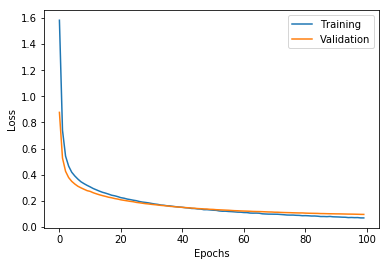

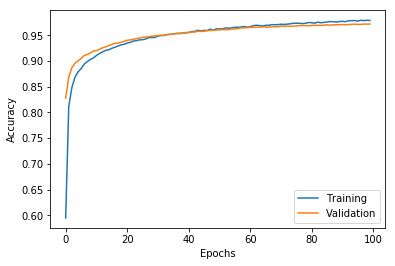

In [77]:
plot_history(dropout_model_history)

Again, let's compare the performance of the model on the training, validation and test set.

In [88]:
dropout_model.evaluate(x_train, y_train)

10000/10000 [==============================] - 6s 593us/step


[0.08850426195478067, 0.9738]

In [88]:
dropout_model.evaluate(x_val, y_val)

10000/10000 [==============================] - 6s 593us/step


[0.08850426195478067, 0.9738]

In [88]:
dropout_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 6s 593us/step


[0.08850426195478067, 0.9738]

## Understanding the model

We should try to gain some insight into the model.  There are several ways to do this.

### Confustion matrix

The model produces some classification errors, it would be interesting to see the type of errors.  Computing a confustion matrix is useful for that prupose.

In [100]:
y_predict_classes = dropout_model.predict_classes(x_test)

In [103]:
y_test_classes = np.argmax(y_test, axis=1)

In [106]:
confusion_matrix(y_test_classes, y_predict_classes)

array([[ 968,    0,    0,    2,    0,    4,    2,    2,    2,    0],
       [   0, 1123,    3,    1,    0,    1,    4,    1,    2,    0],
       [   7,    1, 1002,    5,    1,    1,    2,    8,    5,    0],
       [   0,    0,    4,  990,    0,    6,    0,    4,    4,    2],
       [   0,    1,    5,    0,  958,    0,    3,    2,    2,   11],
       [   3,    0,    0,    9,    2,  864,    7,    1,    5,    1],
       [   6,    3,    0,    0,    9,    8,  929,    0,    3,    0],
       [   1,    8,   11,    0,    2,    0,    0,  995,    2,    9],
       [   5,    0,    3,    5,    3,    4,    6,    5,  941,    2],
       [   4,    5,    1,    8,   10,    2,    1,    7,    3,  968]])

From the confusion matrix, it is clear that, e.g., 2 and 7 get confused, as well as 5 and 9.  Given the data, that should come as no surprise.